# Sioux Falls Scenario

## Import libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Read in data

In [8]:
df = pd.read_csv('../input/trajectory_raw.gz')
df.head()

# from zipfile import ZipFile

# zip_file = ZipFile('../input/test.zip')
# dfs = {csv_file.filename: pd.read_csv(zip_file.open(csv_file.filename))
#        for csv_file in zip_file.infolist()
#        if csv_file.filename.startswith('trajectory')}

# pd.read_csv(zip_file.open('trajectory_data.csv'))

,person_id,veh_id,time,link_id,x,y,act_type,event_type,length,leg_mode
0,32995_1,NaN,18607.0,56_8,685035.768142,4.820794e+06,home,actend,472.250695,NaN
1,32995_1,NaN,18607.0,56_8,685035.768142,4.820794e+06,NaN,departure,472.250695,car
2,32995_1,32995_1,18607.0,NaN,NaN,NaN,NaN,PersonEntersVehicle,NaN,NaN
3,NaN,32995_1,18608.0,56_8,685035.768142,4.820794e+06,NaN,left link,472.250695,NaN
4,NaN,32995_1,18608.0,62_1,684756.632167,4.820559e+06,NaN,entered link,392.476963,NaN
...,...,...,...,...,...,...,...,...,...,...
3855127,37362_2,NaN,96569.0,66_3,682179.585347,4.820435e+06,home,actstart,482.768042,NaN
3855128,10607_3,NaN,97358.0,18_3,686283.369108,4.824809e+06,NaN,arrival,467.672231,walk
3855129,10607_3,NaN,97358.0,18_3,686283.369108,4.824809e+06,home,actstart,467.672231,NaN
3855130,7072_4,NaN,97946.0,14_7,684740.777682,4.830384e+06,NaN,arrival,469.280773,walk


## Explore Data

### Trips per activity

In [3]:
trajectory_raw.act_type.unique().tolist()

['home', nan, 'work', 'pt interaction', 'secondary']

    Activity  Percentage
0       home   50.000000
1       work   33.827131
2  secondary   16.172869


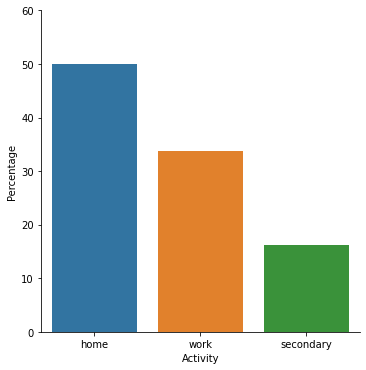

In [4]:
# Plot activity types

## Get "act_type" that are not null
has_activity= trajectory_raw["act_type"].notnull()
temp= trajectory_raw[has_activity]

## Exclude "pt interaction" events -- fake events
pt_interaction= temp["act_type"]== "pt interaction"
temp= temp[~pt_interaction]

## Create Activity/Percentage table
activities= temp.act_type.value_counts()
activities= (activities / len(temp))*100
data= pd.DataFrame(data= {'Activity': activities.index, 'Percentage': activities.values})
print(data)

## Plot graph
g= sns.catplot(x='Activity', y='Percentage', data= data, kind= "bar")
g.ax.set_ylim(0,60)
plt.show()

#TODO
#- Check with MATSim outputs

### Trips per mode

In [5]:
trajectory_raw.leg_mode.unique().tolist()

[nan, 'car', 'walk', 'pt']

   Mode  Percentage
0   car   63.172374
1    pt   21.437028
2  walk   15.390598


(0.0, 80.0)

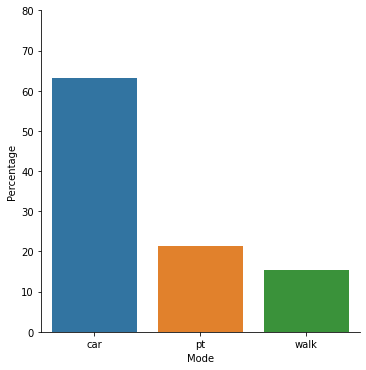

In [6]:
# Plot trajectory main modes

## Get events where "leg_mode" is not null
has_mode= trajectory_raw["leg_mode"].notnull()
temp= trajectory_raw[has_mode]

## Group by 'person_id', 'leg_mode' and count 'leg_mode'
grouped = temp.groupby(['person_id', 'leg_mode']).agg({'leg_mode': 'count'})
grouped.columns = ['leg_count']
grouped = grouped.reset_index()

## Get trajectory main mode -- some heuristics and might not hold tru for different scenarios
grouped= grouped.drop_duplicates(subset=['person_id'],keep='first')

## Create Mode/Percentage table
modes= grouped.leg_mode.value_counts()
modes= (modes / len(grouped))*100
data= pd.DataFrame(data= {'Mode': modes.index, 'Percentage': modes.values})
print(data)

## Plot table
g= sns.catplot(x='Mode', y='Percentage', data= data, kind= "bar")
g.ax.set_ylim(0,80)

#TODO
#- Check with MATSim outputs

In [7]:
#TODO
###Trips per purpose (grouped by mode)

## Transform data

### Remove PuT 

In [8]:
# Remove put users 

## Get pt users
is_pt= trajectory_raw[trajectory_raw['leg_mode']=='pt']
pt_agents= is_pt['person_id'].unique()

## Exclude pt users 
trajectory_cars= trajectory_raw[~(trajectory_raw['person_id'].isin(pt_agents))]
trajectory_cars['leg_mode'].unique().tolist()

#TODO
#- Keep pt users

#Note
#This is just for the sake of simplicity as put events are more detailed

[nan, 'car', 'walk']

In [9]:
# Remove bus drivers

## Get bus drivers
is_driver= trajectory_cars[trajectory_cars['person_id'].str.startswith('pt', na=False)]
bus_drivers= is_driver['person_id'].unique()

## Remove bus drivers
trajectory_cars= trajectory_cars[~(trajectory_cars['person_id'].isin(bus_drivers))]

In [10]:
# Remove buses

## Get buses 
is_bus= trajectory_cars[trajectory_cars['veh_iD'].str.startswith('bus', na=False)]
buses= is_bus['veh_iD'].unique()

## Remove buses
trajectory_cars= trajectory_cars[~(trajectory_cars['veh_iD'].isin(buses))]

## Reconstruct agent trajectories 

In [11]:
# Relabel 'veh_iD' col
trajectory_cars= trajectory_cars.rename(columns={"veh_iD": "veh_id"})

# Check if 'person_id' equals to 'veh_id'
enters_vehicle= trajectory_cars[trajectory_cars['event_type']=='PersonEntersVehicle']

condition= enters_vehicle['person_id']!= enters_vehicle['veh_id']
choice= 1
default= 0

enters_vehicle['driver'] = np.where(condition, choice, default)
enters_vehicle['driver'].sum()

#TODO
#- Delete warning

/Users/lucaslbs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0

In [12]:
# Create 'agent_id' col

conditions = [trajectory_cars['person_id'].notnull(), trajectory_cars['person_id'].isnull()]
choices = [trajectory_cars['person_id'], trajectory_cars['veh_id']]

trajectory_cars['agent_id'] = np.select(conditions, choices)

# Reorder col

cols = trajectory_cars.columns.tolist()
cols = cols[-1:] + cols[:-1]
trajectory_cars = trajectory_cars[cols]
trajectory_cars.head()

trajectory_cars = trajectory_cars[cols]

In [13]:
# Fill in NAs

## Forward fill NAs

cols= ['person_id', 'veh_id', 'link_id', 'x', 'y', 'length', 'leg_mode']

##Loop over collumns 
for col in cols:
    
    ##Forward fill  
    trajectory_cars[col] = trajectory_cars.groupby(['agent_id'])[col].ffill()
    
## Backward fill NAs

cols= ['veh_id', 'leg_mode', 'act_type']

##Loop over collumns 
for col in cols:
    
    ##Backward fill  
    trajectory_cars[col] = trajectory_cars.groupby(['agent_id'])[col].bfill()
    
trajectory_cars.head(10)

,agent_id,person_id,veh_id,time,link_id,x,y,act_type,event_type,length,leg_mode
0,32995_1,32995_1,32995_1,18607.0,56_8,685035.768142,4.820794e+06,home,actend,472.250695,car
1,32995_1,32995_1,32995_1,18607.0,56_8,685035.768142,4.820794e+06,work,departure,472.250695,car
2,32995_1,32995_1,32995_1,18607.0,56_8,685035.768142,4.820794e+06,work,PersonEntersVehicle,472.250695,car
3,32995_1,32995_1,32995_1,18608.0,56_8,685035.768142,4.820794e+06,work,left link,472.250695,car
4,32995_1,32995_1,32995_1,18608.0,62_1,684756.632167,4.820559e+06,work,entered link,392.476963,car
5,32995_1,32995_1,32995_1,18637.0,62_1,684756.632167,4.820559e+06,work,left link,392.476963,car
6,32995_1,32995_1,32995_1,18637.0,62_2,684365.048051,4.820533e+06,work,entered link,392.476963,car
7,32995_1,32995_1,32995_1,18666.0,62_2,684365.048051,4.820533e+06,work,left link,392.476963,car
8,32995_1,32995_1,32995_1,18666.0,62_3,683973.463934,4.820506e+06,work,entered link,392.476963,car
9,32995_1,32995_1,32995_1,18695.0,62_3,683973.463934,4.820506e+06,work,left link,392.476963,car


In [2]:
trajectory_cars.isna().sum()

NameError: name 'trajectory_cars' is not defined

In [14]:
# drop person_id, veh_id 
trajectory_cars= trajectory_cars.drop(['person_id', 'veh_id'], axis=1)

# offset time 
trajectory_cars['time']= trajectory_cars['time'] - 18607

In [15]:
trajectory_cars.head(10)

,agent_id,time,link_id,x,y,act_type,event_type,length,leg_mode
0,32995_1,0.0,56_8,685035.768142,4.820794e+06,home,actend,472.250695,car
1,32995_1,0.0,56_8,685035.768142,4.820794e+06,work,departure,472.250695,car
2,32995_1,0.0,56_8,685035.768142,4.820794e+06,work,PersonEntersVehicle,472.250695,car
3,32995_1,1.0,56_8,685035.768142,4.820794e+06,work,left link,472.250695,car
4,32995_1,1.0,62_1,684756.632167,4.820559e+06,work,entered link,392.476963,car
5,32995_1,30.0,62_1,684756.632167,4.820559e+06,work,left link,392.476963,car
6,32995_1,30.0,62_2,684365.048051,4.820533e+06,work,entered link,392.476963,car
7,32995_1,59.0,62_2,684365.048051,4.820533e+06,work,left link,392.476963,car
8,32995_1,59.0,62_3,683973.463934,4.820506e+06,work,entered link,392.476963,car
9,32995_1,88.0,62_3,683973.463934,4.820506e+06,work,left link,392.476963,car
